## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

**Step 1.**

a. Read in `ab_data.csv` the dataset, store it in `df` and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(15)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df[df['converted'] == 1].shape)[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'old_page')) == True].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()  # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Step 2.** For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Store new dataframe in **df2**.

In [8]:
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page == 'old_page')")
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**Step 3.**

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id']) == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df_cont = df2[df2['group'] == 'control']
df_cont[df_cont['converted'] == 1].shape[0] / df_cont.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df_tret = df2[df2['group'] == 'treatment']
df_tret[df_tret['converted'] == 1].shape[0] / df_tret.shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df_newp = df2[df2['landing_page'] == 'new_page']
df_newp.shape[0] / df2.shape[0]

0.5000619442226688

e. Considering our results from a. through d. above, whether there is sufficient evidence to say that the new treatment page leads to more conversions.

**Observation:**  No. We don't have sufficient evidence to conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we can technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


**step1.** For now, let's consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?

**hypotheses**
- H<sub>0</sub> : **$p_{new}$** - **$p_{old}$** $\leq$ 0
- H<sub>1</sub> : **$p_{new}$** - **$p_{old}$** $>$ 0

**Step2.** Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new_null = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_new_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old_null = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_old_null

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[p_new_null, 1 - p_new_null])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old_null, 1 - p_old_null])
old_page_converted

array([1, 1, 1, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

0.002321726563005555

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []
p_null = 0.11959791040050657
for _ in range(10000):
    new_page_conv = np.random.choice([0,1], size=n_new, p=[1 - p_null,p_null])
    old_page_conv = np.random.choice([0,1], size=n_old, p=[1 - p_null,p_null])
    p_diffs.append(new_page_conv.mean() - old_page_conv.mean())

p_diffs = np.array(p_diffs) 

i. Plot a histogram of the **p_diffs**.

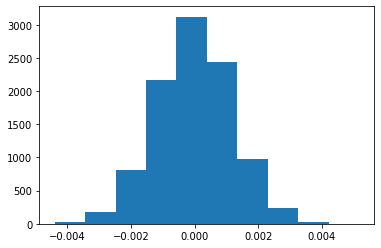

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
(p_diffs > obs_diff).mean()

0.9045

We calculated the ***p-value***. A p-value is used in hypothesis testing to support or reject the null hypothesis. It is the evidence against a null hypothesis. The smaller the p-value, the stronger the evidence that you should reject the null hypothesis. <br>
Our p-value is close to 0.9 which is greater than the alpha value of 0.05. Therefore, the result is not significant and we ***don't reject*** the null hypothesis. 

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_val = proportions_ztest([convert_old, convert_new], [n_old, n_new], 0, alternative='smaller')
z_score, p_val

(1.3109241984234394, 0.9050583127590245)

k. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Observation:** Z scores are measures of standard deviation. If Z score is between *-1.96* and *+1.96*, and p-value are *larger* than *0.05*, we **cannot reject**  null hypothsis. Hence, the z score and p-value ***agree*** with the findings in part *j* and *k*.

<a id='regression'></a>
### Part III - A regression approach

**Step1.** In this final part, we'll see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we should you be performing **Logistic Regression** in this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2['ab_page'] = [1 if x =='treatment' else 0 for x in df2['group']]
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
y = df2['converted']
X = df2[['intercept', 'ab_page']]
log_mod = sm.Logit(y, X)
res = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:33:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**Observation:** <br>
A. **hypothesis associated with regression**
- H<sub>0</sub> : **$p_{new}$** - **$p_{old}$** $\neq$ 0
- H<sub>1</sub> : **$p_{new}$** - **$p_{old}$** $=$ 0

B. **hypothesis in A/B Testing(Part II)**
- H<sub>0</sub> : **$p_{new}$** - **$p_{old}$** $\leq$ 0
- H<sub>1</sub> : **$p_{new}$** - **$p_{old}$** $>$ 0


p-value associated with **ab_page** is **0.190**. It differs from **Part II** because it is calculated for **two-tailed** hypothesis test, whereas hypothesis test in **Part II** was one-tailed.

f. Now, we are considering other things that might influence whether or not an individual converts.  It is a good idea to consider other factors to add into your regression model because Adding other factors is a good approach because the response variable may be strongly correlated with those other variables. It may imrove our R-squared value.

**Disadvanages:** When dealing with multiple variables in regression, following problems may arise: 
1. Non-linearity of the response-predictor relationships
2. Correlation of error terms
3. Non-constant Variance and Normally Distributed Errors
4. Outliers/ High leverage points
5. Multi-collinearity(explanatory variables being correlated to themselves)


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

Does it appear that country had an impact on conversion?

In [33]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [34]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [35]:
y1 = df_new['converted']
X1 = df_new[['intercept', 'CA', 'UK']]
log_mod1 = sm.Logit(y1, X1)
res1 = log_mod1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:34:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Let's create the necessary additional columns, and fit the new model.  

In [37]:
### Fit Your Linear Model And Obtain the Results
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
y2 = df_new['converted']
X2 = df_new[['intercept', 'CA', 'UK', 'ab_page', 'CA_ab_page', 'UK_ab_page']]
log_mod2 = sm.Logit(y2, X2)
res2 = log_mod2.fit()
res2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 25 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        09:49:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

**Part-2**<br>
The Z-score 1.31 is and p-value is 0.90. If Z-score is between *-1.96* and *+1.96*, and p-value are *larger* than *0.05*(alpha), we **cannot reject** null hypothsis. Therefore, we **fail to reject** the null hypothesis.

**Part-3**<br>
- In the first regression test, p-value for *ab_page* is *larger* than *0.05*, we **cannot reject** null hypothsis.

- In second regression test, even after adding explanatory variables for *countries*, there is no significant p-value(all are higher than alpha value of 0.05). Hence, like previous conclusion we **fail to reject** the null hypothesis.   

- In third regression test, explanatory variables created as interaction between page and country have **large  p-values** and therefore they **don't** have significant effects on conversion. Hence, like previous two conclusions we **fail to reject** the null hypothesis.


**Overall Conclusion**<br>

Since we don't have enough evidence that the *new page* is better at converting users, company should **continue** to use the *old page*.



https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
https://www.geeksforgeeks.org/python-creating-a-pandas-dataframe-column-based-on-a-given-condition/